In [43]:
### TensforFlow Hub: Share pretrained model components.
# 1/ How to use TF Hub with tf.keras
# 2/ How to do image classification using TF Hub (In the previous notebook, it took so long to train the CNN)
# 3/ How to do simple transfer learning

In [44]:
from __future__ import absolute_import, division, print_function, unicode_literals

# PyPlot is an interactive way to use Matplotlib
# PyLab is the same thing as PyPlot but with some extra shortcuts.
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)

# import TF Hub
import tensorflow_hub as hub

2.0.0-rc0


In [45]:
# Download an ImageNet classifier (AlexNet ?)

# 1/ Use hub.module to load a mobilenet
# 2/ use layers.Lambda function to wrap it up as a keras layer

URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'

IMAGE_SHAPE = (224, 224)

# Define a model containing the mobilenet only
classifier = tf.keras.Sequential([
    hub.KerasLayer(URL, input_shape = IMAGE_SHAPE + (3, ))]) 

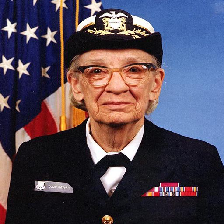

In [46]:
# Let's get a single image and run it on classifier

import PIL.Image as Image

# Downloads a file from a URL 
image = tf.keras.utils.get_file('image.jpg', # Name of the file on YOUR disk
                                'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')


# .open() -> This is a lazy operation; this function identifies the file,
# but the file remains open and the actual image data is not read from the file until you try to process the data
# Return an Image object
image = Image.open(image).resize(IMAGE_SHAPE)
image

In [47]:
# Convert the image in a numpy array and normalize it
image = np.array(image)/255.0
print(image.shape)

(224, 224, 3)


In [48]:
# Add a batch dimenstion before passing the image to the model

print(image[np.newaxis, ...].shape)

result = classifier.predict(image[np.newaxis, ...])
print(result.shape)

# result contains the probability distribution over the classes

(1, 224, 224, 3)
(1, 1001)


In [49]:
# Get the predicted class

predicted_class = np.argmax(result[0])
predicted_class

653

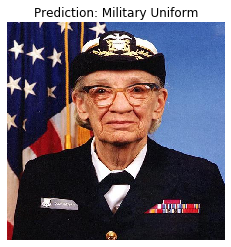

In [52]:
# Let's see what this class index correspond to 

# Downloads the label file from a URL 
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 
                                      'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

# Open the label file, read the whole file
# Split a string into a list where each line is a list item
labels = np.array(open(labels_path).read().splitlines())

# Display the image along with its class name
plt.imshow(image)
plt.axis('off')

predicted_class_name = labels[predicted_class]
_ = plt.title('Prediction: ' + predicted_class_name.title())
plt.show()

In [54]:
### Transfer learning
# Using TF Hub, it is simple to train the TOP layer of the pre-trained model to recognize the classes in OUR dataset

# Our dataset will be composed of flowers pictures

flowers_path = tf.keras.utils.get_file('flower_photos',
                                       'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                       untar = True)
print(flowers_path)
# The path contains directory with folders' name for the class names.
# Each folder contains their corresponding .jpg images

/Users/nicolas/.keras/datasets/flower_photos


In [56]:
# As in 2 - Image classification, let's use an ImageDataGenerator to load the data into our model

# Create an ImageDataGenerator object (recale the image between 0 and 1, it is necessary to use TF Hub models)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

# Create the image dataset
# Takes the path to a directory & generates batches of augmented data.
# It returns an iterator containing (image_batch, label_batch) pairs
flowers_data = image_generator.flow_from_directory(str(flowers_path),
                                                   target_size = IMAGE_SHAPE) # By default, batch_size = 32

Found 3670 images belonging to 5 classes.


In [65]:
# Explore the flowers_data to get more insights

print('flower_data type: ', type(flowers_data))

for image_batch, label_batch in flowers_data:
    print('Image batch shape: ', image_batch.shape)
    print('Label batch shape: ', label_batch.shape)
    break
    

flower_data type:  <class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)
flower_data first element:  (32, 224, 224, 3)


In [66]:
# Run the classifier on a batch of images

result_batch = classifier.predict(image_batch)
print(result_batch.shape) # For each image in the batch, get the probability distribution over the class labels

(32, 1001)


In [67]:
# Extract the most likely class for each image
predicted_class_names = labels[np.argmax(result_batch, axis = -1)]
print(predicted_class_names)

['daisy' 'vase' 'vase' 'artichoke' 'snail' 'cardoon' 'daisy' 'daisy'
 'daisy' 'chickadee' 'pot' 'pot' 'daisy' 'pot' 'daisy' 'daisy' 'briard'
 'pot' 'buckeye' 'Bedlington terrier' 'cardoon' 'hair slide' 'bolo tie'
 'daisy' 'daisy' 'sulphur butterfly' 'bee' 'daisy' 'hip' 'picket fence'
 'vase' 'daisy']


<Figure size 720x648 with 0 Axes>

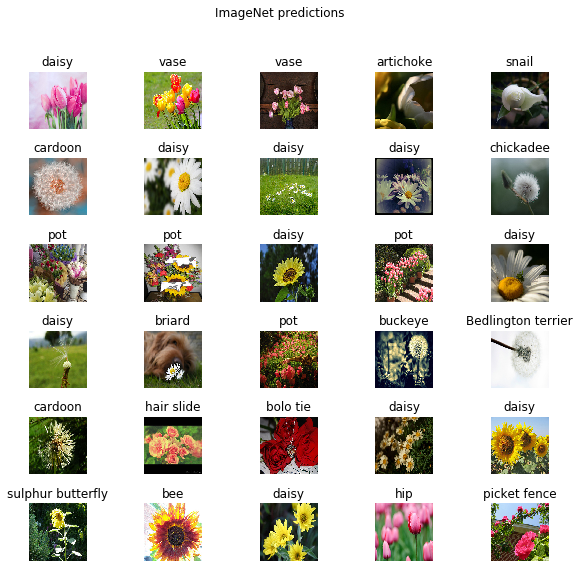

In [69]:
# Check how these prediction match with the images

plt.figure(figsize = (10, 9))
plt.subplots_adjust(hspace = 0.5) # the amount of height reserved for space between subplots

# Plot the first 30 images in the batch only
for image_index in range(30):
    plt.subplot(6, 5, image_index+1) # Add a subplot to the current figure (grid of 6 by 5)
    plt.imshow(image_batch[image_index])
    plt.title(predicted_class_names[image_index])
    plt.axis('off')
    plt.suptitle('ImageNet predictions')
    
plt.show()

In [70]:
# Results are okay given that the classes are not the ones the network has been trained on
# (Our dataset contains 5 classes, the trained model contains 1000 classes)

# Now let's download the classifier WITHOUT the output layer.
# So that we can add our own output layer and use transfer learning.

URL_WITHOUT_TOP = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

In [71]:
# Wrap up the mobilenet network as a keras layer

# Call it feature_extract since we removed the classification layer
feature_extract_layer = hub.KerasLayer(URL_WITHOUT_TOP,
                                       input_shape = (224, 224, 3))


In [72]:
# Test the layer on a batch of 32 images

feature_extract_layer_output = feature_extract_layer(image_batch)
print(feature_extract_layer_output.shape)

# For each image, we get a vector of 1280 entries. This vector is called feature vector

(32, 1280)


In [73]:
# Freeze the parameters in the feature_extract_layer to only train the LAST layer(our own layer)

feature_extract_layer.trainable = False

In [75]:
# Construct our model by adding our own output layer

model = tf.keras.Sequential([feature_extract_layer,
                             layers.Dense(flowers_data.num_classes, activation = 'softmax')])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [76]:
# Note that there is only 6'405 trainable parameters
# Now let's use our model to make the prediction on the first batch flower images

predictions = model(image_batch)
print(predictions.shape) # Note that there is only 5 classes

(32, 5)


In [78]:
### Train our model on the flower images (only the output layer will be trained)

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy', # one-hot encoded, otherwise use sparse
              metrics = ['accuracy'])

In [80]:
# To visualize the training process, we'll use a custom callback to keep track
# of the loss and accuracy of EACH batch indidually instead of the epoch AVERAGE
# (So when keras display the loss and metrics while learning,
# it is actually the average loss/metrics over the current epoch)

class CollectBatchStats(tf.keras.callbacks.Callback):
    '''Collect the loss and accuracy of EACH batch indidually instead of the epoch AVERAGE
    '''
    
    def __init__(self):
        # Use list to keep tract the the loss, accuracy
        self.batch_losses = []
        self.batch_acc = []
        
    def on_train_batch_end(self, batch, logs = None):
        ''' Called at the end of a training batch in fit methods.
        '''
        
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        # Access to the model and reset the state of metrics.
        self.model.reset_metrics()

In [81]:
# Compute the number of images per epoch
steps_per_epoch = np.ceil(flowers_data.samples/flowers_data.batch_size)

# Initialize a custom callback
batch_stats_callback = CollectBatchStats()

# Train the model
history = model.fit_generator(flowers_data,
                              epochs = 2, # We don't need that much epochs since we use a pretrained model
                              steps_per_epoch = steps_per_epoch, # Number of images per epoch
                              callbacks = [batch_stats_callback]) # Add your customer callback

Epoch 1/2


W0915 12:40:29.962775 140736140276608 deprecation.py:323] From /Users/nicolas/anaconda/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 539s 5s/step - loss: 0.6854 - accuracy: 0.8750

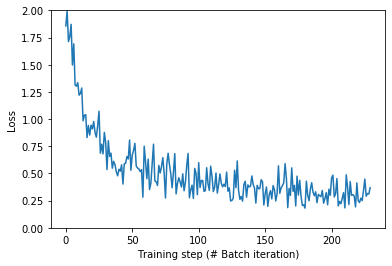

In [85]:
### Visualize the results (loss)

plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training step (# Batch iteration)') # (3'670 images / batch_size = 32) -> 114 images per batch * number of epochs -> 228 training steps
plt.ylim([0, 2])
plt.plot(batch_stats_callback.batch_losses) # Get the loss history from the callback object
plt.show()

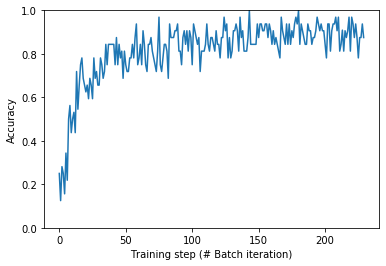

In [86]:
### Visualize the results (add)

plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training step (# Batch iteration)')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc) # Get the loss history from the callback object
plt.show()

In [91]:
# Let's check the predictions of the model

# First, we need to get the class names ordered (which class correspond to which integer)
# The dictionary containing the mapping from class names to class indices
# can be obtained via the attribute class_indices

# items() -> Get the list of all (K, V) pairs
print('Class mapping: ', flowers_data.class_indices)
class_names = sorted(flowers_data.class_indices.items(), key = lambda pair: pair[1]) # Sort the array in increasing label index order
class_names = np.array([key.title() for key, value in class_names]) # Keep only the class names
print('Class names: ', class_names)

Class mapping:  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
Class names:  ['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


In [96]:
# Get the predictions of the 1st image batch and convert them into class names

predictions = model.predict(image_batch)
predictions_id = np.argmax(predictions, axis = -1)
predictions_class_name = class_names[predictions_id]

# Get the correct label of the image_batch
correct_class_id = np.argmax(label_batch, axis = -1)

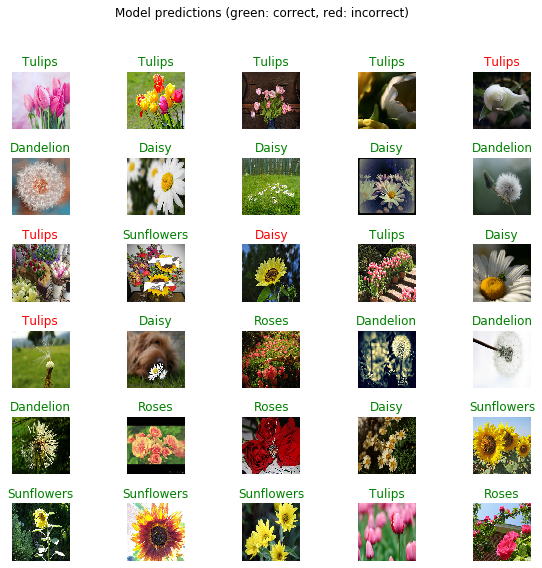

In [99]:
# Plot the predictions

plt.figure(figsize = (10, 9))
plt.subplots_adjust(hspace = 0.5)

# First 30 images in the 1st batch
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    # If the prediction is correct, write the prediction in green, otherwise in red
    if predictions_id[n] == correct_class_id[n]:
        color = 'green'
    else:
        color = 'red'
    plt.title(predictions_class_name[n].title(), color = color)
    plt.axis('off')
    plt.suptitle('Model predictions (green: correct, red: incorrect)')

plt.show()

In [101]:
# Now that our model is trained, we can export it

import time

t_0 = time.time()

export_path = 'tmp/saved_models{}'.format(int(t_0)) # Use the time to make the path unique

# Save the model on the disk
tf.keras.experimental.export_saved_model(model, export_path)
print(export_path)

W0915 14:39:42.650756 140736140276608 deprecation.py:323] From <ipython-input-101-5b065d2cdee4>:10: export_saved_model (from tensorflow.python.keras.saving.saved_model_experimental) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.
W0915 14:39:45.236186 140736140276608 deprecation.py:506] From /Users/nicolas/anaconda/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0915 14:39:49.373645 140736140276608 deprecation.py:323] From /Users/nicolas/anaconda/lib/python3.6/site-packages/tensorflow_core/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.p

tmp/saved_models1568551182


In [102]:
# Check wether we can reload it and obtain the same results

# customer_objects -> dictionary mapping names (strings) to custom classes
reloaded_model = tf.keras.experimental.load_from_saved_model(export_path,
                                                             custom_objects = {'KerasLayer': hub.KerasLayer})

W0915 14:42:44.398195 140736140276608 deprecation.py:323] From <ipython-input-102-5035df9a7200>:5: load_from_saved_model (from tensorflow.python.keras.saving.saved_model_experimental) is deprecated and will be removed in a future version.
Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.
W0915 14:42:46.017951 140736140276608 util.py:144] Unresolved object in checkpoint: (root).optimizer.beta_1
W0915 14:42:46.020101 140736140276608 util.py:144] Unresolved object in checkpoint: (root).optimizer.beta_2
W0915 14:42:46.022117 140736140276608 util.py:144] Unresolved object in checkpoint: (root).optimizer.decay
W0915 14:42:46.024939 140736140276608 util.py:144] Unresolved object in checkpoint: (root).optimizer.learning_rate
W0915 14:42:46.027220 140736140276608 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'm' for (root).layer_with_weights-1.kernel
W0915 14:42:46.029265 14073614027

In [103]:
# Compare the results of the 2 models

results = model.predict(image_batch)
reloaded_results = reloaded_model.predict(image_batch)

print('Difference between the 2 models: ', abs(reloaded_results - results).max())

Difference between the 2 models:  0.0
